In [2]:
!pip install timm

import os
import gc
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
# ==========================================
# 0. MEMORY CLEANUP
# ==========================================
gc.collect()
torch.cuda.empty_cache()

# ==========================================
# 1. CONFIGURATION
# ==========================================
class Config:
    DATA_DIR = '/kaggle/input/rsna-bone-age'
    IMG_SIZE = 300       
    BATCH_SIZE = 16      # Keep 16 to avoid OOM with dual backbones
    EPOCHS = 30          
    LR = 0.0003          
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42
    # NEW: How often to print inside an epoch
    LOG_INTERVAL = 10    

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.SEED)

In [4]:
# ==========================================
# 2. DATASET (Fixed with Train/Val Split)
# ==========================================
print(f"Loading Metadata from {Config.DATA_DIR}...")
df = pd.read_csv(os.path.join(Config.DATA_DIR, 'boneage-training-dataset.csv'))

# Process Gender
df['gender_encoded'] = df['male'].astype(float)

# Create file paths
df['path'] = df['id'].apply(lambda x: os.path.join(Config.DATA_DIR, 'boneage-training-dataset/boneage-training-dataset', f'{x}.png'))

# --- SPLIT DATA ---
train_df, test_df = train_test_split(df, test_size=0.3, random_state=Config.SEED)

test_df, val_df = train_test_split(df, test_size=0.5, random_state=Config.SEED)

# Reset indices to avoid KeyError during training
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Training Samples: {len(train_df)}")
print(f"Validation Samples: {len(val_df)}")

class RSNABoneAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Use .iloc for safety
        row = self.df.iloc[idx]
        image_path = row['path']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            image = self.transform(image)
            
        age = torch.tensor(row['boneage'], dtype=torch.float32)
        gender = torch.tensor(row['gender_encoded'], dtype=torch.float32)
        return image, gender, age

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = RSNABoneAgeDataset(train_df, transform=train_transform)
val_dataset = RSNABoneAgeDataset(val_df, transform=val_transform)

# test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

print(test_df.shape)

# CHANGE: num_workers=2, pin_memory=False (Safe Mode)
train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=False)

print("✅ Dataset and Loaders ready.")

Loading Metadata from /kaggle/input/rsna-bone-age...
Training Samples: 8827
Validation Samples: 6306
(6305, 5)
✅ Dataset and Loaders ready.


In [5]:
# ==========================================
# 3. MODEL (Paper Figure 6)
# ==========================================
class TwoStageFusionNetwork(nn.Module):
    def __init__(self):
        super(TwoStageFusionNetwork, self).__init__()
        self.xception = timm.create_model('xception', pretrained=True, num_classes=0) 
        self.resnet = timm.create_model('resnet50', pretrained=True, num_classes=0)
        
        self.feature_dim = self.xception.num_features + self.resnet.num_features
        self.gender_fc = nn.Linear(1, 32) 
        
        self.regressor = nn.Sequential(
            nn.Linear(self.feature_dim + 32, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, x, gender):
        feat_xception = self.xception(x)
        feat_resnet = self.resnet(x)
        feat_fused = torch.cat((feat_xception, feat_resnet), dim=1)
        
        gender = gender.unsqueeze(1)
        feat_gender = self.gender_fc(gender)
        
        final_input = torch.cat((feat_fused, feat_gender), dim=1)
        return self.regressor(final_input).squeeze()

# Initialize and Parallelize
print("Initializing Model...")
model = TwoStageFusionNetwork()
if torch.cuda.device_count() > 1:
    print(f"✅ Using {torch.cuda.device_count()} GPUs with DataParallel")
    model = nn.DataParallel(model)
else:
    print(f"⚠️ Only 1 GPU detected.")

model = model.to(Config.DEVICE)

Initializing Model...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


✅ Using 2 GPUs with DataParallel


In [6]:
# ==========================================
# FIX: RE-DEFINE DATASET & LOADERS
# ==========================================

# 1. Reset Indices (Crucial for avoiding indexing errors after split)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

class RSNABoneAgeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # FIX: Explicitly use .iloc for integer-location based indexing
        row = self.df.iloc[idx]
        
        image_path = row['path']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
            
        age = torch.tensor(row['boneage'], dtype=torch.float32)
        gender = torch.tensor(row['gender_encoded'], dtype=torch.float32)
        
        return image, gender, age

# 2. Re-create Loaders with the fixed Dataset
train_dataset = RSNABoneAgeDataset(train_df, transform=train_transform)
val_dataset = RSNABoneAgeDataset(val_df, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

print("✅ Dataset and Loaders fixed.")

✅ Dataset and Loaders fixed.


In [7]:
# ==========================================
# 4. TRAINING LOOP (Verbose + Fixed Warnings)
# ==========================================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)
mae_metric = nn.L1Loss()

# FIX 1: Use torch.amp.GradScaler('cuda') to fix deprecation warning
scaler = torch.amp.GradScaler('cuda')

print("Starting Training Loop...")
best_mae = float('inf')

for epoch in range(Config.EPOCHS):
    print(f"\n{'='*20} EPOCH {epoch+1}/{Config.EPOCHS} {'='*20}")
    
    # --- TRAINING PHASE ---
    model.train()
    running_loss = 0.0
    start_time = time.time()
    num_batches = len(train_loader)
    
    for i, (images, genders, ages) in enumerate(train_loader):
        images = images.to(Config.DEVICE)
        genders = genders.to(Config.DEVICE)
        ages = ages.to(Config.DEVICE)
        
        optimizer.zero_grad()
        
        # FIX 2: Use torch.amp.autocast('cuda') to fix deprecation warning
        with torch.amp.autocast('cuda'):
            outputs = model(images, genders)
            loss = criterion(outputs, ages)
        
        # Backward & Step
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        loss_val = loss.item()
        running_loss += loss_val * images.size(0)
        
        # VERBOSE LOGGING INSIDE EPOCH
        if (i + 1) % Config.LOG_INTERVAL == 0:
            elapsed = time.time() - start_time
            # Estimate remaining time
            avg_time_per_batch = elapsed / (i + 1)
            remaining_batches = num_batches - (i + 1)
            eta = remaining_batches * avg_time_per_batch
            
            print(f"  [Batch {i+1:03d}/{num_batches}] "
                  f"Train Loss: {loss_val:.2f} | "
                  f"ETA: {eta:.0f}s")
        
    epoch_loss = running_loss / len(train_loader.dataset)
    train_time = time.time() - start_time
    print(f"  >>> Training Finished. Avg Loss: {epoch_loss:.4f} | Time: {train_time:.0f}s")
    
    # --- VALIDATION PHASE ---
    print(f"  >>> Starting Validation...")
    model.eval()
    val_loss = 0.0
    val_mae = 0.0
    val_start = time.time()
    
    with torch.no_grad():
        for i, (images, genders, ages) in enumerate(val_loader):
            images = images.to(Config.DEVICE)
            genders = genders.to(Config.DEVICE)
            ages = ages.to(Config.DEVICE)
            
            with torch.amp.autocast('cuda'):
                outputs = model(images, genders)
                loss = criterion(outputs, ages)
                mae = mae_metric(outputs, ages)
            
            val_loss += loss.item() * images.size(0)
            val_mae += mae.item() * images.size(0)
            
    val_loss = val_loss / len(val_loader.dataset)
    val_mae = val_mae / len(val_loader.dataset)
    val_time = time.time() - val_start
    
    print(f"  >>> Validation Finished. Time: {val_time:.0f}s")
    print(f"  RESULTS EPOCH {epoch+1}:")
    print(f"  ------------------------")
    print(f"  Train MSE: {epoch_loss:.4f}")
    print(f"  Val MSE  : {val_loss:.4f}")
    print(f"  Val MAE  : {val_mae:.4f} months")

    # --- SAVE LOGIC ---
    state_dict = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()

    # Save Checkpoint (Every Epoch)
    checkpoint_name = f'model_epoch_{epoch+1}.pth'
    torch.save(state_dict, checkpoint_name)
    print(f"  💾 Saved Checkpoint: {checkpoint_name}")

    # Save Best Model
    if val_mae < best_mae:
        prev_best = best_mae
        best_mae = val_mae
        torch.save(state_dict, 'best_bone_age_model.pth')
        print(f"  🏆 NEW BEST MODEL! (MAE improved from {prev_best:.4f} to {best_mae:.4f})")
    else:
        print(f"  (Best MAE is still {best_mae:.4f})")

print("\nAll Training Completed.")

Starting Training Loop...

==================== EPOCH 1/30 ====================
  [Batch 010/552] Train Loss: 15634.26 | ETA: 433s
  [Batch 020/552] Train Loss: 12489.23 | ETA: 322s
  [Batch 030/552] Train Loss: 5997.62 | ETA: 284s
  [Batch 040/552] Train Loss: 937.11 | ETA: 265s
  [Batch 050/552] Train Loss: 1332.74 | ETA: 253s
  [Batch 060/552] Train Loss: 678.88 | ETA: 243s
  [Batch 070/552] Train Loss: 693.42 | ETA: 236s
  [Batch 080/552] Train Loss: 595.80 | ETA: 228s
  [Batch 090/552] Train Loss: 445.38 | ETA: 221s
  [Batch 100/552] Train Loss: 472.71 | ETA: 214s
  [Batch 110/552] Train Loss: 501.06 | ETA: 208s
  [Batch 120/552] Train Loss: 720.52 | ETA: 203s
  [Batch 130/552] Train Loss: 1068.60 | ETA: 197s
  [Batch 140/552] Train Loss: 413.69 | ETA: 191s
  [Batch 150/552] Train Loss: 616.95 | ETA: 186s
  [Batch 160/552] Train Loss: 202.64 | ETA: 181s
  [Batch 170/552] Train Loss: 390.14 | ETA: 176s
  [Batch 180/552] Train Loss: 112.44 | ETA: 171s
  [Batch 190/552] Train Loss: 3

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


  >>> Validation Finished. Time: 151s
  RESULTS EPOCH 1:
  ------------------------
  Train MSE: 1265.3136
  Val MSE  : 248.6875
  Val MAE  : 12.8976 months
  💾 Saved Checkpoint: model_epoch_1.pth
  🏆 NEW BEST MODEL! (MAE improved from inf to 12.8976)

==================== EPOCH 2/30 ====================
  [Batch 010/552] Train Loss: 129.58 | ETA: 344s
  [Batch 020/552] Train Loss: 270.35 | ETA: 290s
  [Batch 030/552] Train Loss: 159.43 | ETA: 268s
  [Batch 040/552] Train Loss: 175.83 | ETA: 252s
  [Batch 050/552] Train Loss: 185.20 | ETA: 241s
  [Batch 060/552] Train Loss: 552.48 | ETA: 234s
  [Batch 070/552] Train Loss: 414.95 | ETA: 226s
  [Batch 080/552] Train Loss: 146.96 | ETA: 219s
  [Batch 090/552] Train Loss: 97.39 | ETA: 212s
  [Batch 100/552] Train Loss: 274.73 | ETA: 206s
  [Batch 110/552] Train Loss: 772.43 | ETA: 201s
  [Batch 120/552] Train Loss: 145.29 | ETA: 195s
  [Batch 130/552] Train Loss: 600.17 | ETA: 191s
  [Batch 140/552] Train Loss: 312.79 | ETA: 186s
  [Batch 

In [9]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = RSNABoneAgeDataset(test_df, transform=test_transform)

# test_df = pd.read_csv('/kaggle/input/rsna-bone-age/boneage-test-dataset.csv')

print(test_df.shape)

# CHANGE: num_workers=2, pin_memory=False (Safe Mode)
test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=False)

(6305, 5)


Loading best model for inference...
✅ Using 2 GPUs for Inference
Running predictions on test set...


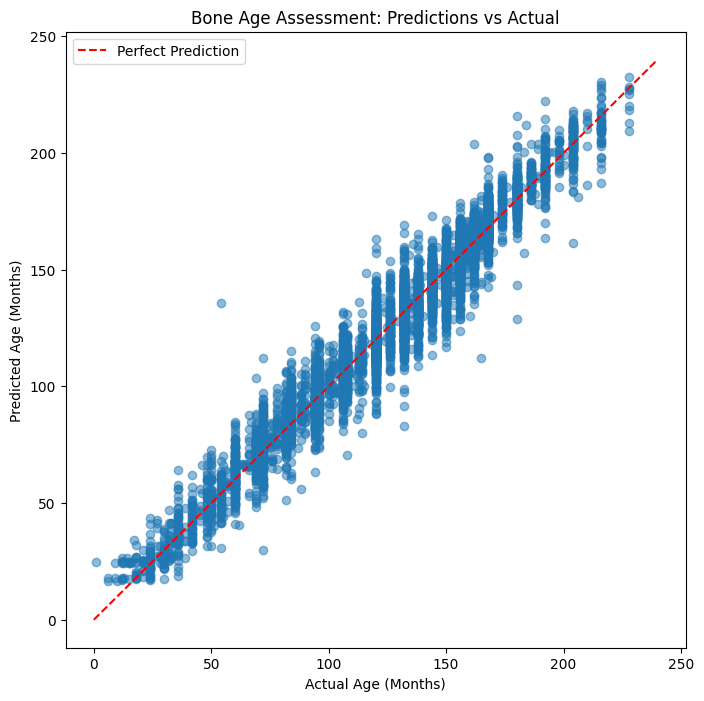

Final Test MAE: 6.8162 months


In [11]:
# ==========================================
# 5. INFERENCE / VISUALIZATION (Fixed Loading)
# ==========================================
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

print("Loading best model for inference...")

# 1. Initialize the base model (DO NOT wrap in DataParallel yet)
model = TwoStageFusionNetwork()

# 2. Load the state dictionary
# Using map_location ensures it loads onto the correct device initially
state_dict = torch.load('best_bone_age_model.pth', map_location=Config.DEVICE)
model.load_state_dict(state_dict)

# 3. NOW wrap in DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"✅ Using {torch.cuda.device_count()} GPUs for Inference")
    model = nn.DataParallel(model)

# 4. Move to device
model = model.to(Config.DEVICE)
model.eval()

preds = []
actuals = []

print("Running predictions on test set...")
with torch.no_grad():
    for images, genders, ages in val_loader:
        images = images.to(Config.DEVICE)
        genders = genders.to(Config.DEVICE)
        
        # Forward pass
        outputs = model(images, genders)
        
        preds.extend(outputs.cpu().numpy())
        actuals.extend(ages.cpu().numpy())

# Plotting
plt.figure(figsize=(8, 8))
plt.scatter(actuals, preds, alpha=0.5)
plt.plot([0, 240], [0, 240], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel("Actual Age (Months)")
plt.ylabel("Predicted Age (Months)")
plt.title("Bone Age Assessment: Predictions vs Actual")
plt.legend()
plt.show()

print(f"Final Test MAE: {mean_absolute_error(actuals, preds):.4f} months")

Generating predictions on Validation Set...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(



>> Regression MAE: 6.8162 months
>> Classification Accuracy: 0.8855
>> Classification QWK: 0.8936


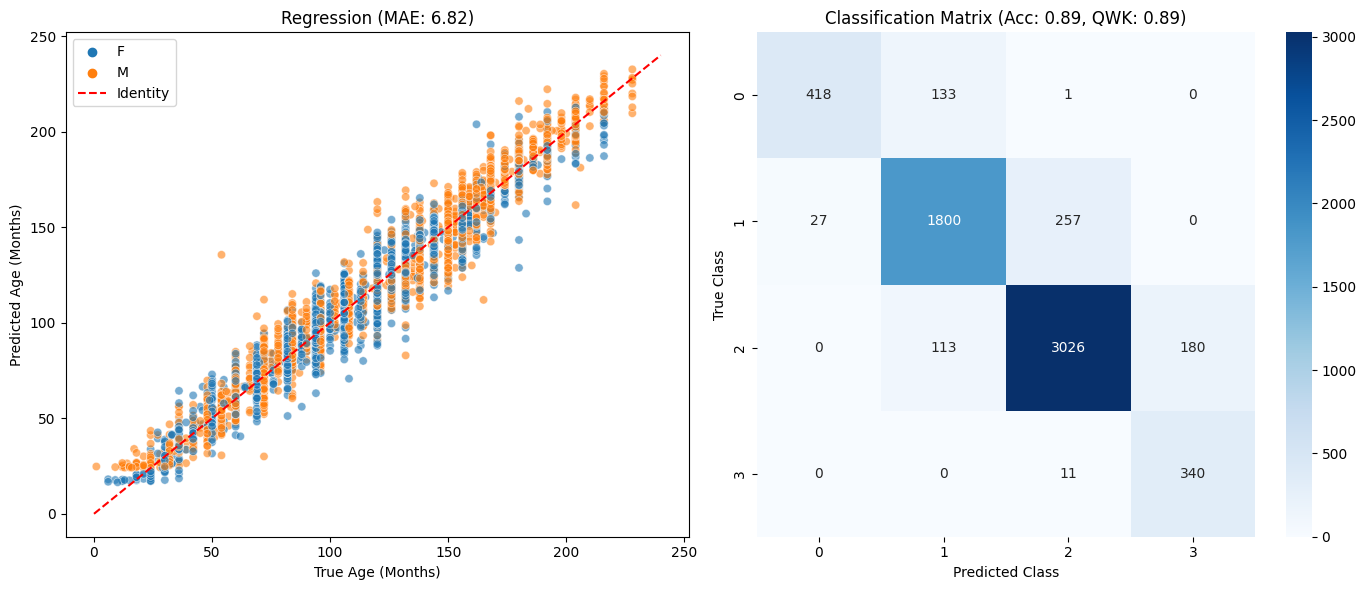

In [12]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, accuracy_score, cohen_kappa_score, confusion_matrix
from torch.utils.data import DataLoader

# ==========================================
# 1. SETUP & LOAD DATA (Must match training config)
# ==========================================
# Define the bins from the uploaded file for Classification Metrics
AGE_BINS = [0, 60, 120, 180, 300]
AGE_LABELS = [0, 1, 2, 3]

# Ensure the dataset and model classes are defined (run your previous cells first)
# If running in a new notebook, copy the Config, Dataset, and Model classes here.

print("Generating predictions on Validation Set...")

# Load the best saved model
model = TwoStageFusionNetwork()
# If you trained on multiple GPUs, the state_dict might need adjustment, 
# but the previous saving code handled 'module.' prefix removal, so this should work directly:
try:
    model.load_state_dict(torch.load('best_bone_age_model.pth', map_location=Config.DEVICE))
except Exception as e:
    print(f"Standard load failed, trying to handle DataParallel wrapper: {e}")
    # Fallback if saved with 'module.' prefix
    state_dict = torch.load('best_bone_age_model.pth', map_location=Config.DEVICE)
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k.replace("module.", "") # remove `module.`
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)

model.to(Config.DEVICE)
model.eval()

# ==========================================
# 2. RUN INFERENCE
# ==========================================
actuals = []
predictions = []
genders_list = []

# Use the validation loader defined in your training script
with torch.no_grad():
    for images, genders, ages in val_loader:
        images = images.to(Config.DEVICE)
        genders_gpu = genders.to(Config.DEVICE)
        
        # Get regression output
        outputs = model(images, genders_gpu)
        
        actuals.extend(ages.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())
        genders_list.extend(genders.numpy())

actuals = np.array(actuals)
predictions = np.array(predictions)

# ==========================================
# 3. CALCULATE METRICS
# ==========================================

# --- Metric A: Regression MAE ---
mae = mean_absolute_error(actuals, predictions)
print(f"\n>> Regression MAE: {mae:.4f} months")

# --- Metric B & C: Classification Accuracy & QWK ---
# Convert continuous ages to buckets (bins) as per the instruction file
def bucket_ages(ages):
    return pd.cut(ages, bins=AGE_BINS, labels=AGE_LABELS, include_lowest=True).astype(int)

# Bucket the Ground Truth and Predictions
y_test_cls = bucket_ages(actuals)
pred_cls = bucket_ages(predictions)

# Accuracy
acc = accuracy_score(y_test_cls, pred_cls)
print(f">> Classification Accuracy: {acc:.4f}")

# Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test_cls, pred_cls, weights='quadratic')
print(f">> Classification QWK: {qwk:.4f}")

# ==========================================
# 4. VISUALIZATION (Matches Uploaded File style)
# ==========================================
plt.figure(figsize=(14, 6))

# Plot 1: Regression Scatter
plt.subplot(1, 2, 1)
# Map 0/1 gender back to M/F for coloring
gender_labels = ['M' if g==1 else 'F' for g in genders_list]
sns.scatterplot(x=actuals, y=predictions, hue=gender_labels, alpha=0.6)
plt.plot([0, 240], [0, 240], 'r--', label='Identity')
plt.title(f"Regression (MAE: {mae:.2f})")
plt.xlabel("True Age (Months)")
plt.ylabel("Predicted Age (Months)")
plt.legend()

# Plot 2: Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test_cls, pred_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f"Classification Matrix (Acc: {acc:.2f}, QWK: {qwk:.2f})")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


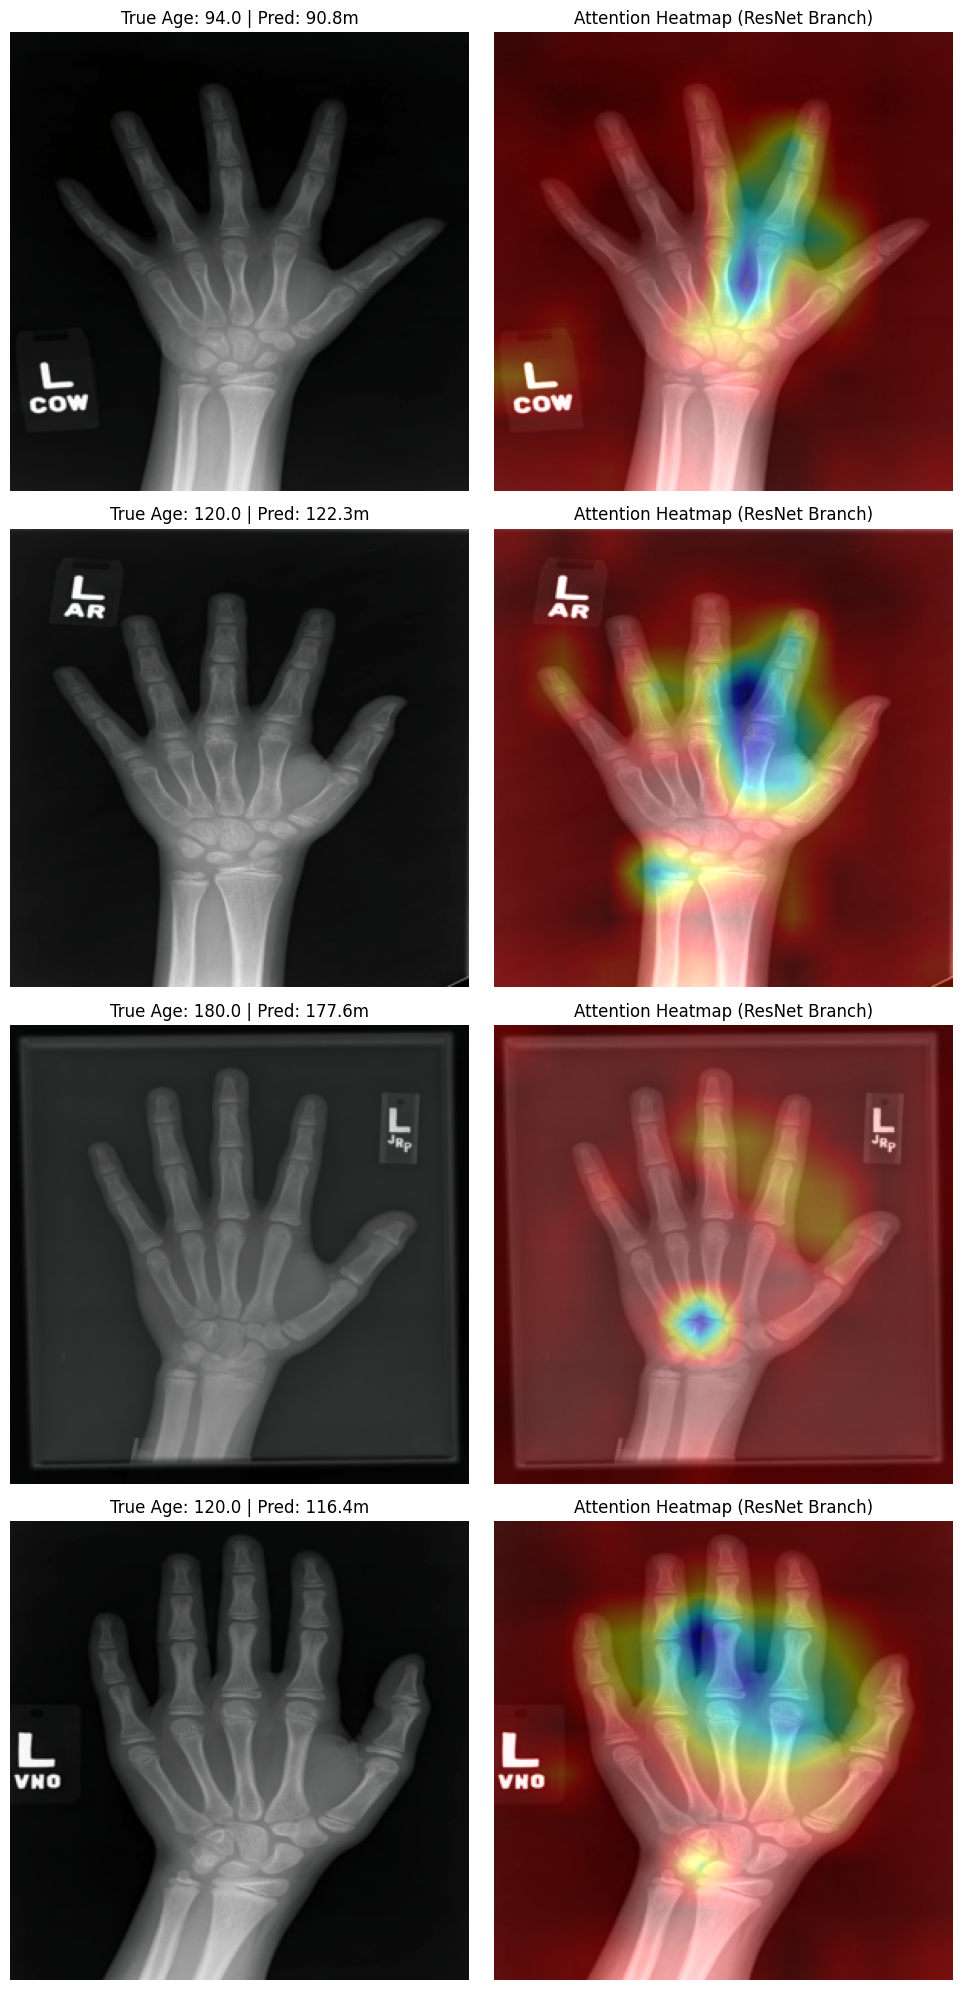

In [13]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

# ==========================================
# 1. GRAD-CAM UTILITY CLASS
# ==========================================
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        # Hooks to capture gradients and activations
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, gender):
        # 1. Forward Pass
        # We need to manually handle the model's forward pass logic to isolate the output
        # properly for backprop, or just run the full model forward.
        # Here we run full model forward.
        output = self.model(x, gender)
        
        # 2. Zero grads
        self.model.zero_grad()
        
        # 3. Backward Pass (target is the predicted age itself)
        # We assume regression, so we backpropagate from the output scalar
        output.backward()

        # 4. Generate Heatmap
        # Pool the gradients across the channels
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        
        # Weight the activations by the gradients
        # (Batch size is 1 for visualization loop usually, so index 0)
        activation = self.activations[0]
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        # Average the channels to get a 2D heatmap
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        
        # 5. Normalize (ReLU + MinMax)
        heatmap = np.maximum(heatmap, 0) # ReLU
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
            
        return heatmap, output.item()

# ==========================================
# 2. SETUP FOR VISUALIZATION
# ==========================================
# Load best model
model = TwoStageFusionNetwork()
# Handle DataParallel loading
state_dict = torch.load('best_bone_age_model.pth', map_location=Config.DEVICE)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k.replace("module.", "") 
    new_state_dict[name] = v
model.load_state_dict(new_state_dict)

model.to(Config.DEVICE)
model.eval()

# TARGET LAYER: Layer 4 of the ResNet50 branch
# This is usually where high-level spatial features (like bone shapes) exist.
target_layer = model.resnet.layer4[-1] 
grad_cam = GradCAM(model, target_layer)

# ==========================================
# 3. GENERATE & PLOT
# ==========================================
def show_cam_on_image(img_tensor, heatmap):
    # Convert tensor to numpy image
    img = img_tensor.cpu().numpy().transpose(1, 2, 0)
    img = (img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406] # Un-normalize
    img = np.clip(img, 0, 1)
    img = np.uint8(255 * img)

    # Resize heatmap to image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # Convert to color map
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay
    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    
    return img, superimposed_img

# Pick a batch from validation
images, genders, ages = next(iter(val_loader))
images = images.to(Config.DEVICE)
genders = genders.to(Config.DEVICE)

# Plot first 4 images
num_images = 4
fig, axes = plt.subplots(num_images, 2, figsize=(10, 5 * num_images))

for i in range(num_images):
    # Run Grad-CAM for single image
    input_img = images[i].unsqueeze(0) # Add batch dim
    input_gender = genders[i].unsqueeze(0)
    
    # Enable grad for visualization even in eval mode
    with torch.set_grad_enabled(True):
        heatmap, pred_age = grad_cam(input_img, input_gender)
    
    # Create overlay
    orig_img, cam_img = show_cam_on_image(images[i], heatmap)
    
    # Plot Original
    axes[i, 0].imshow(orig_img)
    axes[i, 0].set_title(f"True Age: {ages[i].item():.1f} | Pred: {pred_age:.1f}m")
    axes[i, 0].axis('off')
    
    # Plot Heatmap
    axes[i, 1].imshow(cam_img)
    axes[i, 1].set_title("Attention Heatmap (ResNet Branch)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

# Two Stage Architecture

In [14]:
import os
import gc
import cv2
import time
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [15]:
# ==========================================
# 0. CONFIGURATION
# ==========================================
class Config:
    DATA_DIR = '/kaggle/input/rsna-bone-age'
    LOAD_SIZE = 512      # Load high-res for better crops
    CROP_SIZE = 299      # Input size for Xception/ResNet
    BATCH_SIZE = 16      
    EPOCHS = 30
    LR = 0.0003
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    SEED = 42

def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(Config.SEED)

In [16]:
# ==========================================
# 1. DUAL-INPUT DATASET (Heuristic Cropping)
# ==========================================
class TwoStageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        
        # Load High-Res Image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (Config.LOAD_SIZE, Config.LOAD_SIZE))
        
        h, w, _ = image.shape
        
        # --- STAGE 1 LOGIC (Simulated) ---
        # Heuristic: Wrist is bottom 40%, Fingers are top 70%
        # Region A: Metacarpal (Fingers) -> For ResNet
        metacarpal_img = image[0:int(h*0.7), 0:w] 
        
        # Region B: Carpal (Wrist) -> For Xception
        carpal_img = image[int(h*0.6):h, 0:w] 
        
        # Apply Transforms
        if self.transform:
            metacarpal_img = self.transform(metacarpal_img)
            carpal_img = self.transform(carpal_img)
            
        age = torch.tensor(row['boneage'], dtype=torch.float32)
        gender = torch.tensor(row['gender_encoded'], dtype=torch.float32)
        
        return carpal_img, metacarpal_img, gender, age

# Setup Data
df = pd.read_csv(os.path.join(Config.DATA_DIR, 'boneage-training-dataset.csv'))
df['gender_encoded'] = df['male'].astype(float)
df['path'] = df['id'].apply(lambda x: os.path.join(Config.DATA_DIR, 'boneage-training-dataset/boneage-training-dataset', f'{x}.png'))
train_df, val_df = train_test_split(df, test_size=0.2, random_state=Config.SEED)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

data_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((Config.CROP_SIZE, Config.CROP_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_loader = DataLoader(TwoStageDataset(train_df, data_transform), batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(TwoStageDataset(val_df, data_transform), batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=2)

In [17]:
# ==========================================
# 2. TRUE STAGE 2 NETWORK (Dual Stream)
# ==========================================
class TrueStage2Network(nn.Module):
    def __init__(self):
        super(TrueStage2Network, self).__init__()
        
        # Stream 1: Carpal (Wrist) -> Xception
        self.carpal_net = timm.create_model('xception', pretrained=True, num_classes=0)
        
        # Stream 2: Metacarpal (Fingers) -> ResNet50
        self.meta_net = timm.create_model('resnet50', pretrained=True, num_classes=0)
        
        # Fusion
        self.concat_dim = self.carpal_net.num_features + self.meta_net.num_features
        self.gender_fc = nn.Linear(1, 32)
        
        self.regressor = nn.Sequential(
            nn.Linear(self.concat_dim + 32, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
        
    def forward(self, carpal_img, meta_img, gender):
        # Forward pass for training
        carpal_feat = self.carpal_net(carpal_img)
        meta_feat = self.meta_net(meta_img)
        
        img_feat = torch.cat((carpal_feat, meta_feat), dim=1)
        gender_feat = self.gender_fc(gender.unsqueeze(1))
        
        combined = torch.cat((img_feat, gender_feat), dim=1)
        return self.regressor(combined).squeeze()

    # Specialized forward methods for Grad-CAM
    def forward_carpal(self, x):
        return self.carpal_net(x)

    def forward_meta(self, x):
        return self.meta_net(x)

# Initialize
print("Initializing True Two-Stage Model...")
model = TrueStage2Network()

# --- PRINT ARCHITECTURE ---
print("\n" + "="*30)
print("MODEL ARCHITECTURE")
print("="*30)
print(model)
print("="*30 + "\n")

if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)
model = model.to(Config.DEVICE)

Initializing True Two-Stage Model...


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(



MODEL ARCHITECTURE
TrueStage2Network(
  (carpal_net): Xception(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act1): ReLU(inplace=True)
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act2): ReLU(inplace=True)
    (block1): Block(
      (skip): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (skipbn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (rep): Sequential(
        (0): SeparableConv2d(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
          (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        )
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [18]:
# ==========================================
# 3. GRAD-CAM VISUALIZER
# ==========================================
class BranchGradCAM:
    def __init__(self, model_branch, target_layer):
        self.model_branch = model_branch
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        
        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate(self, x):
        # Single branch forward/backward
        output = self.model_branch(x)
        self.model_branch.zero_grad()
        
        # Target: maximize the sum of features (proxy for activation)
        target = output.sum()
        target.backward(retain_graph=True)
        
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0].detach()
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0: heatmap /= np.max(heatmap)
        return heatmap

def visualize_predictions(model, loader, num_samples=3):
    print("\nGenerating Heatmaps for Wrist (Xception) and Fingers (ResNet)...")
    
    # Handle DataParallel unwrapping
    base_model = model.module if isinstance(model, nn.DataParallel) else model
    base_model.eval()
    
    # Setup GradCAM hooks
    # Xception target: Last conv layer (usually 'conv4' or within 'act4' block in timm)
    # We try to find the last conv layer dynamically or hardcode for standard timm xception
    cam_wrist = BranchGradCAM(base_model.carpal_net, base_model.carpal_net.conv4) 
    
    # ResNet target: Layer 4
    cam_finger = BranchGradCAM(base_model.meta_net, base_model.meta_net.layer4[-1])

    # Get data
    carpal_imgs, meta_imgs, genders, ages = next(iter(loader))
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    
    for i in range(num_samples):
        # Inputs
         wrist_in = carpal_imgs[i].unsqueeze(0).to(Config.DEVICE)
         finger_in = meta_imgs[i].unsqueeze(0).to(Config.DEVICE)
         
         # Generate Maps
         hm_wrist = cam_wrist.generate(wrist_in)
         hm_finger = cam_finger.generate(finger_in)
         
         # Prepare Images
         img_w = wrist_in.cpu().squeeze().numpy().transpose(1,2,0)
         img_w = (img_w * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
         img_w = np.clip(img_w, 0, 1)
         
         img_f = finger_in.cpu().squeeze().numpy().transpose(1,2,0)
         img_f = (img_f * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
         img_f = np.clip(img_f, 0, 1)

         # Overlays
         hm_w_rez = cv2.resize(hm_wrist, (299, 299))
         overlay_w = (cv2.applyColorMap(np.uint8(255*hm_w_rez), cv2.COLORMAP_JET) * 0.4 + img_w*255).astype(np.uint8)

         hm_f_rez = cv2.resize(hm_finger, (299, 299))
         overlay_f = (cv2.applyColorMap(np.uint8(255*hm_f_rez), cv2.COLORMAP_JET) * 0.4 + img_f*255).astype(np.uint8)

         # Plot
         axes[i, 0].imshow(img_w); axes[i, 0].set_title("Wrist Input")
         axes[i, 1].imshow(overlay_w); axes[i, 1].set_title("Xception Attention")
         axes[i, 2].imshow(img_f); axes[i, 2].set_title("Finger Input")
         axes[i, 3].imshow(overlay_f); axes[i, 3].set_title("ResNet Attention")
         
         for ax in axes[i]: ax.axis('off')
         
    plt.show()

In [19]:
# ==========================================
# 4. TRAINING LOOP
# ==========================================
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=Config.LR)
scaler = torch.amp.GradScaler('cuda')
best_mae = float('inf')

print("Starting Training...")

for epoch in range(Config.EPOCHS):
    model.train()
    running_loss = 0.0
    start_time = time.time()
    
    for i, (wrist, finger, gender, age) in enumerate(train_loader):
        wrist, finger = wrist.to(Config.DEVICE), finger.to(Config.DEVICE)
        gender, age = gender.to(Config.DEVICE), age.to(Config.DEVICE)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(wrist, finger, gender)
            loss = criterion(outputs, age)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        running_loss += loss.item() * wrist.size(0)
        
        if i % 100 == 0:
            print(f"  Epoch {epoch+1} Batch {i} Loss: {loss.item():.2f}")

    # Validation
    model.eval()
    val_mae = 0.0
    with torch.no_grad():
        for wrist, finger, gender, age in val_loader:
            wrist, finger = wrist.to(Config.DEVICE), finger.to(Config.DEVICE)
            gender, age = gender.to(Config.DEVICE), age.to(Config.DEVICE)
            with torch.amp.autocast('cuda'):
                outputs = model(wrist, finger, gender)
                val_mae += nn.L1Loss()(outputs, age).item() * wrist.size(0)
    
    val_mae /= len(val_loader.dataset)
    print(f"Epoch {epoch+1} Done. Val MAE: {val_mae:.4f} months. Time: {time.time()-start_time:.0f}s")
    
    if val_mae < best_mae:
        best_mae = val_mae
        state = model.module.state_dict() if isinstance(model, nn.DataParallel) else model.state_dict()
        torch.save(state, 'best_two_stage_model.pth')
        print("  💾 Model Saved!")

Starting Training...
  Epoch 1 Batch 0 Loss: 18378.28
  Epoch 1 Batch 100 Loss: 431.79
  Epoch 1 Batch 200 Loss: 611.09
  Epoch 1 Batch 300 Loss: 567.39
  Epoch 1 Batch 400 Loss: 349.28
  Epoch 1 Batch 500 Loss: 328.73
  Epoch 1 Batch 600 Loss: 185.51
Epoch 1 Done. Val MAE: 12.4452 months. Time: 311s
  💾 Model Saved!
  Epoch 2 Batch 0 Loss: 226.49
  Epoch 2 Batch 100 Loss: 214.62
  Epoch 2 Batch 200 Loss: 221.91
  Epoch 2 Batch 300 Loss: 225.57
  Epoch 2 Batch 400 Loss: 475.89
  Epoch 2 Batch 500 Loss: 199.06
  Epoch 2 Batch 600 Loss: 34.92
Epoch 2 Done. Val MAE: 15.9532 months. Time: 308s
  Epoch 3 Batch 0 Loss: 141.89
  Epoch 3 Batch 100 Loss: 285.24
  Epoch 3 Batch 200 Loss: 209.14
  Epoch 3 Batch 300 Loss: 215.58
  Epoch 3 Batch 400 Loss: 164.97
  Epoch 3 Batch 500 Loss: 65.45
  Epoch 3 Batch 600 Loss: 299.89
Epoch 3 Done. Val MAE: 10.9690 months. Time: 311s
  💾 Model Saved!
  Epoch 4 Batch 0 Loss: 73.99
  Epoch 4 Batch 100 Loss: 280.15
  Epoch 4 Batch 200 Loss: 153.59
  Epoch 4 Ba


Loading best model for visualization...

Generating Heatmaps for Wrist (Xception) and Fingers (ResNet)...


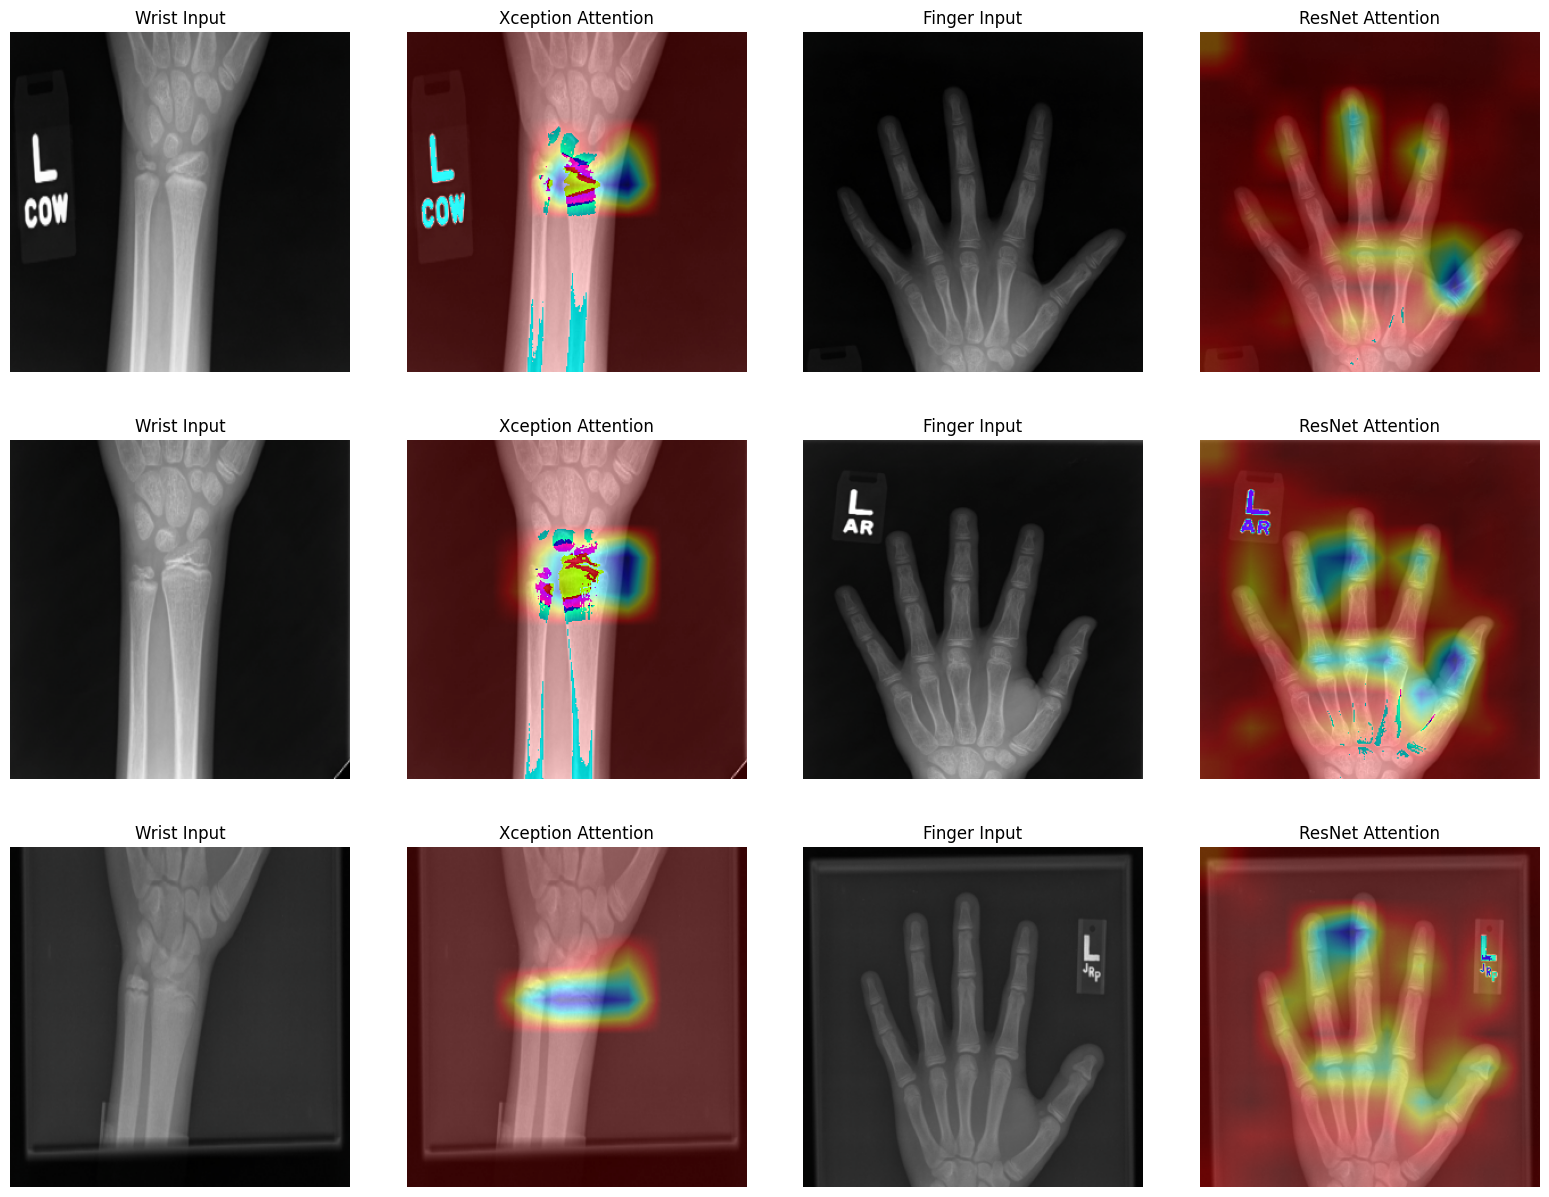

In [20]:
# ==========================================
# 5. VISUALIZE RESULTS
# ==========================================
# Load best model and show heatmaps
print("\nLoading best model for visualization...")
model_state = torch.load('best_two_stage_model.pth', map_location=Config.DEVICE)
if isinstance(model, nn.DataParallel):
    model.module.load_state_dict(model_state)
else:
    model.load_state_dict(model_state)

visualize_predictions(model, val_loader)


FINAL EVALUATION ON TESTING SET
Loading best model weights...
Generating predictions...

>> Regression MAE: 7.9487 months
>> Classification Accuracy: 0.8656
>> Classification QWK: 0.8750


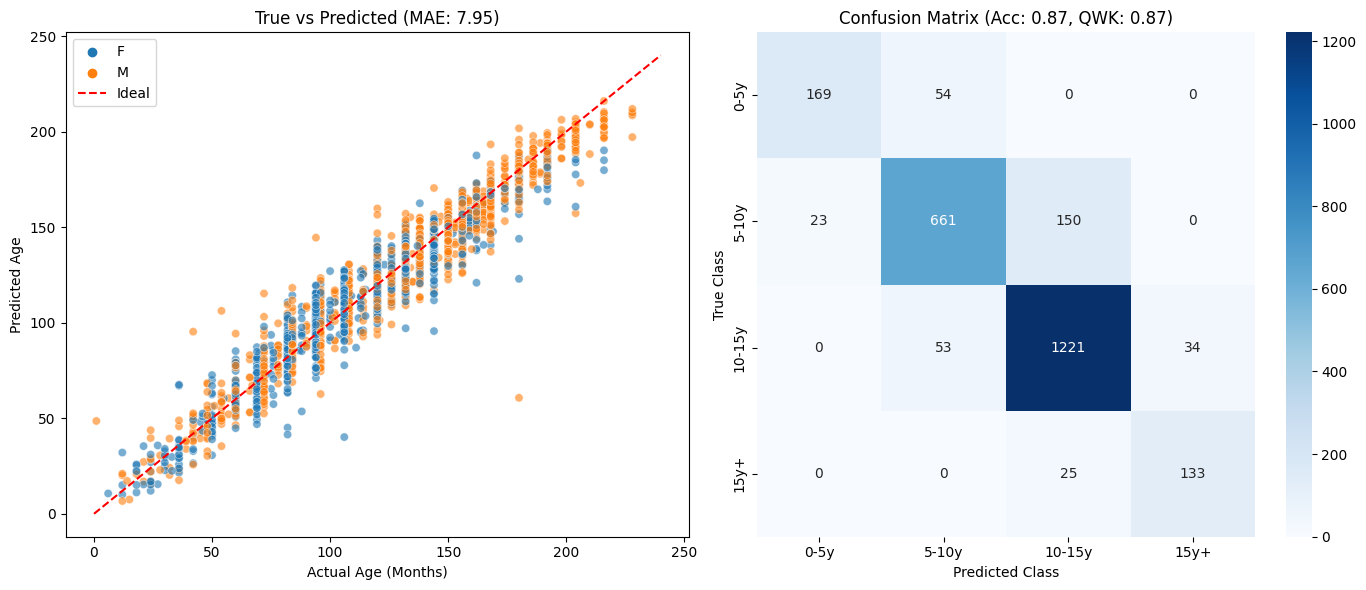

In [22]:
from sklearn.metrics import mean_absolute_error, accuracy_score, cohen_kappa_score, confusion_matrix
import seaborn as sns

# ==========================================
# 6. CALCULATE ALL METRICS (MAE, Acc, QWK)
# ==========================================
print("\n" + "="*30)
print("FINAL EVALUATION ON TESTING SET")
print("="*30)

# 1. Load the Best Model
print("Loading best model weights...")
model = TrueStage2Network()
state_dict = torch.load('best_two_stage_model.pth', map_location=Config.DEVICE)
# Handle DataParallel wrapper if present in saved file
from collections import OrderedDict
clean_state = OrderedDict()
for k, v in state_dict.items():
    clean_state[k.replace("module.", "")] = v
model.load_state_dict(clean_state)

model.to(Config.DEVICE)
model.eval()

# 2. Run Inference
actuals = []
preds = []
genders_list = []

print("Generating predictions...")
with torch.no_grad():
    # Note: Using the new Two-Stage Loader structure
    for carpal, meta, gender, age in val_loader:
        carpal = carpal.to(Config.DEVICE)
        meta = meta.to(Config.DEVICE)
        gender = gender.to(Config.DEVICE)
        
        # Forward Pass
        outputs = model(carpal, meta, gender)
        
        # Collect Data
        preds.extend(outputs.cpu().numpy())
        actuals.extend(age.numpy())
        genders_list.extend(gender.cpu().numpy())

actuals = np.array(actuals)
preds = np.array(preds)

# 3. METRIC A: Regression MAE
mae = mean_absolute_error(actuals, preds)
print(f"\n>> Regression MAE: {mae:.4f} months")

# 4. METRIC B & C: Classification Metrics
# Define Bins (Matches your provided ipynb instructions)
AGE_BINS = [0, 60, 120, 180, 300]
AGE_LABELS = [0, 1, 2, 3]

def bucket_ages(ages):
    return pd.cut(ages, bins=AGE_BINS, labels=AGE_LABELS, include_lowest=True).astype(int)

y_cls = bucket_ages(actuals)
p_cls = bucket_ages(preds)

# Accuracy
acc = accuracy_score(y_cls, p_cls)
print(f">> Classification Accuracy: {acc:.4f}")

# QWK
qwk = cohen_kappa_score(y_cls, p_cls, weights='quadratic')
print(f">> Classification QWK: {qwk:.4f}")

# 5. PLOTS
plt.figure(figsize=(14, 6))

# Regression Scatter
plt.subplot(1, 2, 1)
gender_labels = ['M' if g==1 else 'F' for g in genders_list]
sns.scatterplot(x=actuals, y=preds, hue=gender_labels, alpha=0.6)
plt.plot([0, 240], [0, 240], 'r--', label='Ideal')
plt.title(f"True vs Predicted (MAE: {mae:.2f})")
plt.xlabel("Actual Age (Months)")
plt.ylabel("Predicted Age")
plt.legend()

# Confusion Matrix
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_cls, p_cls)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['0-5y', '5-10y', '10-15y', '15y+'],
            yticklabels=['0-5y', '5-10y', '10-15y', '15y+'])
plt.title(f"Confusion Matrix (Acc: {acc:.2f}, QWK: {qwk:.2f})")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")

plt.tight_layout()
plt.show()